<a href="https://colab.research.google.com/github/pr1me1/learning_lab/blob/master/practise/custom_datasets/fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch kaggle torchinfo tqdm pillow

In [4]:
!export KAGGLE_API_TOKEN=KGAT_23646b633759593115b2c132f4cbf8c3

In [5]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("shreyapmaher/fruits-dataset-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits-dataset-images' dataset.
Path to dataset files: /kaggle/input/fruits-dataset-images


In [6]:
!mkdir -p /content/fruits
!cp -r {path}/* /content/fruits/

set_dir = Path("/content/fruits")

In [7]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
      print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(Path(set_dir))

There are 1 directories and 0 images in /content/fruits
There are 9 directories and 0 images in /content/fruits/images
There are 0 directories and 40 images in /content/fruits/images/grapes fruit
There are 0 directories and 40 images in /content/fruits/images/apple fruit
There are 0 directories and 40 images in /content/fruits/images/orange fruit
There are 0 directories and 40 images in /content/fruits/images/cherry fruit
There are 0 directories and 40 images in /content/fruits/images/chickoo fruit
There are 0 directories and 40 images in /content/fruits/images/kiwi fruit
There are 0 directories and 40 images in /content/fruits/images/mango fruit
There are 0 directories and 40 images in /content/fruits/images/banana fruit
There are 0 directories and 40 images in /content/fruits/images/strawberry fruit


In [8]:
main_set_path = set_dir / "images"

main_set_path.exists()

True

In [9]:
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import random

random.seed(42)

class CustomFruitDataset(Dataset):
    def __init__(self, root_dir, transform=None, split_ratio: list = [0.8, 0.1, 0.1], target: str = "train"):
        self.transforms = transform
        self.root_dir = Path(root_dir)

        self.class_names = sorted(entry.name for entry in root_dir.iterdir() if entry.is_dir())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        all_paths = list(self.root_dir.glob("*/*.jpg"))

        random.shuffle(all_paths)

        total_len = len(all_paths)
        train_end = int(split_ratio[0] * total_len)
        val_end = int((split_ratio[0] + split_ratio[1]) * total_len)

        if target == "train":
            self.paths = all_paths[:train_end]
        elif target == "val":
            self.paths = all_paths[train_end:val_end]
        elif target == "test":
            self.paths = all_paths[val_end:]
        else:
            raise ValueError(f"Invalid target '{target}'. Must be 'train', 'val', or 'test'.")

    def load_image(self, index: int):
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)

        if self.transforms:
            img = self.transforms(img)

        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        return img, class_idx

In [10]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor()
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor()
    ]
)

In [11]:
train_set = CustomFruitDataset(
    root_dir=main_set_path,
    transform=train_transforms,
    target="train",
)

len(train_set)

252

In [12]:
validation_set = CustomFruitDataset(
    root_dir=main_set_path,
    transform=test_transforms,
    target="val",
)

len(validation_set), validation_set[0][0].shape

(31, torch.Size([3, 224, 224]))

In [13]:
test_set = CustomFruitDataset(
    root_dir=main_set_path,
    transform=test_transforms,
    target="test",
)

len(test_set), test_set[0][0].shape

(32, torch.Size([3, 224, 224]))

In [14]:
class_names = test_set.class_names
class_names, test_set.class_to_idx

(['apple fruit',
  'banana fruit',
  'cherry fruit',
  'chickoo fruit',
  'grapes fruit',
  'kiwi fruit',
  'mango fruit',
  'orange fruit',
  'strawberry fruit'],
 {'apple fruit': 0,
  'banana fruit': 1,
  'cherry fruit': 2,
  'chickoo fruit': 3,
  'grapes fruit': 4,
  'kiwi fruit': 5,
  'mango fruit': 6,
  'orange fruit': 7,
  'strawberry fruit': 8})

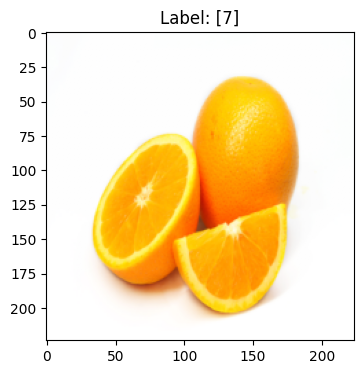

torch.Size([3, 224, 224])

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4, 4))

img, label = test_set[0]
plt.imshow(img.permute(1,2,0))
plt.title(f"Label: {[label]}")
plt.show()

img.shape

In [16]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

validation_loader = DataLoader(
    dataset=validation_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_loader, validation_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7c781766b5c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c7912e9aed0>)

In [17]:
from torch import nn
from torchinfo import summary
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

class FruitClassifier(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56, out_features=output_shape)
    )

  def forward(self, tensor: torch.Tensor):
    tensor = self.layer1(tensor)
    tensor = self.layer2(tensor)
    tensor = self.classifier(tensor)
    return tensor


model = FruitClassifier(input_shape=img.shape[0], hidden_units=64, output_shape=len(class_names)).to(device)
summary(model=model, input_size=(BATCH_SIZE, img.shape[0], img.shape[1], img.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
FruitClassifier                          [16, 9]                   --
├─Sequential: 1-1                        [16, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [16, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [16, 64, 112, 112]        --
├─Sequential: 1-2                        [16, 64, 56, 56]          --
│    └─Conv2d: 2-6                       [16, 64, 112, 112]        36,928
│    └─ReLU: 2-7                         [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 64, 112, 112]        36,928
│    └─ReLU: 2-9                         [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-10                   [16, 64, 56, 56]          --


In [18]:
import torch

def accuracy_fn(y_true, y_pred):
  equals = torch.eq(y_true, y_pred).sum().item()
  return (equals / len(y_pred)) * 100

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

In [20]:
def train_steps(
    dataloader,
    model,
    loss_fn,
    optimizer,
    acc_fn,
    device = device
):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    logits = model(x)
    loss = loss_fn(logits, y)
    train_loss += loss.item()
    train_acc += acc_fn(y, logits.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc


In [21]:
def validation_steps(
    dataloader,
    model,
    loss_fn,
    acc_fn,
    device = device
):
  validation_loss, validation_acc = 0, 0
  model.to(device)
  with torch.inference_mode():
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(device), y.to(device)
      logits = model(x)
      loss = loss_fn(logits, y)
      validation_loss += loss.item()
      validation_acc += acc_fn(y, logits.argmax(dim=1))
  validation_loss /= len(dataloader)
  validation_acc /= len(dataloader)
  return validation_loss, validation_acc

In [22]:
def eval_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    acc_fn: nn.Module,
    device = device
):
  model.to(device)
  loss, acc = 0, 0
  with torch.inference_mode():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      logits = model(x)
      loss += loss_fn(logits, y)
      acc += acc_fn(y, logits.argmax(dim=1))
    loss /= len(dataloader)
    acc /= len(dataloader)

  return {
      "model": model.__class__.__name__,
      "loss": loss.item(),
      "accuracy": acc
  }

In [23]:
from tqdm.auto import tqdm

def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    acc_fn,
    epochs,
    device = device
):
  results = {
      "train_loss": [],
      "train_acc": [],
      "validation_loss": [],
      "validation_acc": []
  }

  for epoch in range(epochs):
    train_loss, train_acc = train_steps(
        train_dataloader,
        model,
        loss_fn,
        optimizer,
        acc_fn,
        device,
    )
    validation_loss, validation_acc = validation_steps(
        test_dataloader,
        model,
        loss_fn,
        acc_fn,
        device
    )

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f}% | "
            f"validation_loss: {validation_loss:.4f} | "
            f"validation_acc: {validation_acc:.4f}%"
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["validation_loss"].append(validation_loss.item() if isinstance(validation_loss, torch.Tensor) else validation_loss)
    results["validation_acc"].append(validation_acc.item() if isinstance(validation_acc, torch.Tensor) else validation_acc)

  return results

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2

model_results = train(
    model,
    train_loader,
    validation_loader,
    optimizer,
    loss_fn,
    accuracy_fn,
    epochs
)

Epoch: 1 | train_loss: 0.4859 | train_acc: 86.0677% | validation_loss: 0.5451 | validation_acc: 87.2917%
Epoch: 2 | train_loss: 0.2642 | train_acc: 92.8385% | validation_loss: 0.6080 | validation_acc: 83.9583%


In [34]:
from typing import Dict, List, Tuple

def plot_curve_function(
    results: Dict[str, List[float]]
):
  train_loss = results["train_loss"]
  test_loss = results["validation_loss"]

  train_acc = results["train_acc"]
  test_acc = results["validation_acc"]

  epochs = range(len(results["validation_acc"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label='train_acc')
  plt.plot(epochs, test_acc, label='validation_acc')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()


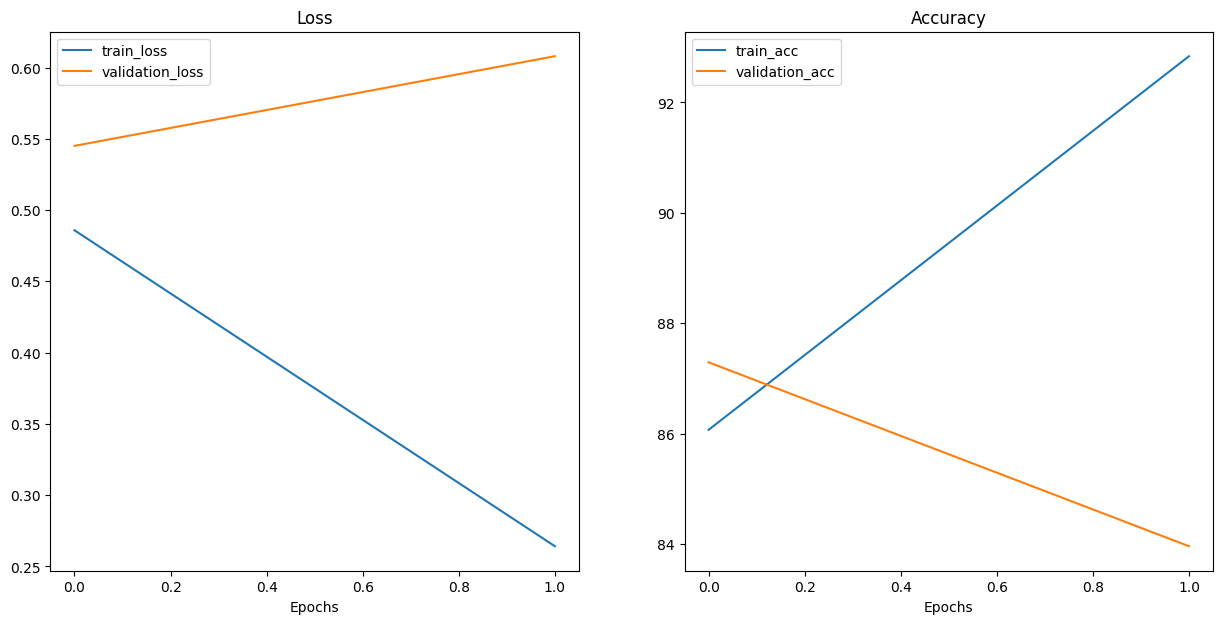

In [35]:
plot_curve_function(model_results)

In [36]:
eval = eval_model(
    model=model,
    dataloader=test_loader,
    loss_fn=loss_fn,
    acc_fn = accuracy_fn
)
eval

{'model': 'FruitClassifier', 'loss': 1.5184354782104492, 'accuracy': 78.125}

In [37]:
test_predictions = []

model.to(device)
for batch, (x, y) in enumerate(test_loader):
  x, y = x.to(device), y.to(device)
  with torch.inference_mode():
    logits = model(x)
    test_predictions += logits.argmax(dim=1).tolist()

test_predictions[:10]

[7, 5, 6, 8, 4, 1, 6, 5, 8, 1]

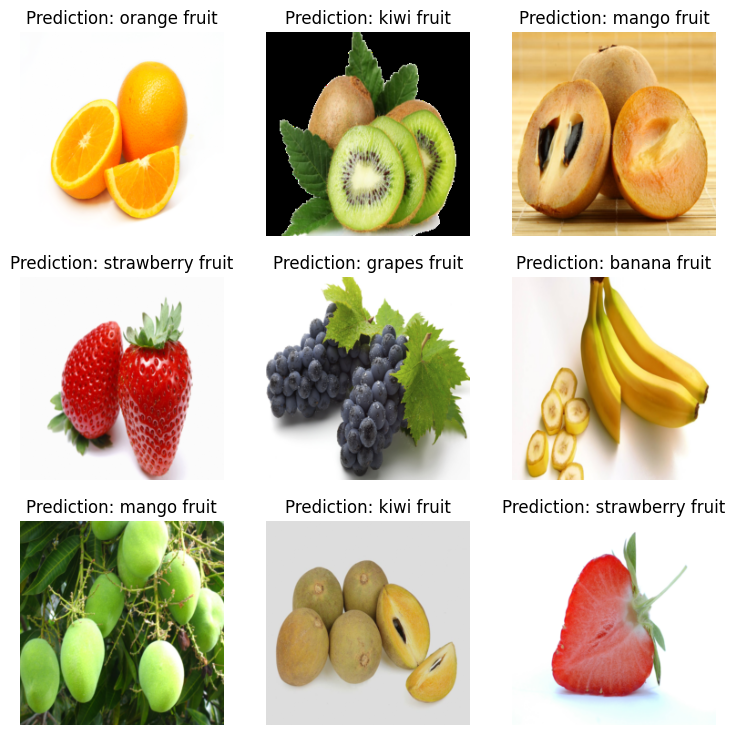

In [38]:
def display_test(
    loader,
    predcitions,
):
  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, (image_batch, labels_batch) in enumerate(loader):
    for j in range(min(image_batch.shape[0], nrows * ncols - i * image_batch.shape[0])):
      if (i * image_batch.shape[0] + j) >= len(predcitions):
          break

      img = image_batch[j].to("cpu")
      img_display = img.permute(1, 2, 0)

      plt.subplot(nrows, ncols, i * image_batch.shape[0] + j + 1)
      plt.imshow(img_display)
      predicted_label_index = predcitions[i * image_batch.shape[0] + j]
      plt.title(f"Prediction: {class_names[predicted_label_index]}")
      plt.axis(False)
  plt.show()


display_test(test_loader, test_predictions)